In [26]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
import sklearn
import itertools
import cv2
import scipy
import os
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import seaborn as sns
from google.colab import drive
import pickle

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive/ECE-176

/content/drive/.shortcut-targets-by-id/1nocF8OwSC30SO-c6lZ_zjX725MCTIjid/ECE-176


In [3]:
basePath = os.getcwd()
num_classes = 4

In [4]:
# Helper Functions

def fetch_data(path_to_folder1, path_to_folder2, path_to_folder3, path_to_folder4, label_dict):
  # define lists to hold image data and corresponding labels
  data = []
  labels = []

  # loop through each folder and read images
  for folder in [path_to_folder1, path_to_folder2, path_to_folder3, path_to_folder4]:
      for filename in os.listdir(folder):
          img = cv2.imread(os.path.join(folder, filename))
          if img is not None:
              # resize image if needed
              # img = cv2.resize(img, (256, 256))
              # img = cv2.resize(img, (80, 60))
              img = cv2.resize(img, dsize=(80,60), interpolation=cv2.INTER_CUBIC)
              # convert image to numpy array and append to data list
              data.append(np.array(img))
              # get label from folder name and append to labels list
              label = label_dict[os.path.basename(folder)]
              labels.append(label)

  data, labels = np.array(data), np.array(labels)
  # data = np.transpose(data, (0, 3, 1, 2)) # rearranges shape from (369, 256, 256, 3) to (369, 3, 256, 256)

  return data, labels

In [18]:
# Helper Functions  Learning Curves and Confusion Matrix
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
#This function prints and plots the confusion matrix.
#Normalization can be applied by setting `normalize=True`.

    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig('./loss_curve.png')

def shuffle_data(data, labels):
  '''shuffle data and labels together'''

  indices = np.arange(len(data))
  np.random.shuffle(indices)
  data = data[indices]
  labels = labels[indices]

  return data, labels

In [6]:
# Load original Data
# p1 = basePath + '/dataset-master/JPEGImages/classes/EOSINOPHIL'
# p2 = basePath + '/dataset-master/JPEGImages/classes/LYMPHOCYTE'
# p3 =  basePath + '/dataset-master/JPEGImages/classes/MONOCYTE'
# p4 =  basePath + '/dataset-master/JPEGImages/classes/NEUTROPHIL'

# # define dictionary to map folder name to label
# label_dict = {'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}

# data_loaded, labels_loaded = fetch_data(p1, p2, p3, p4, label_dict)

In [7]:
# Load augmented data
p1 = basePath + '/dataset-master/GAN AUGMENTED DATA/eos'
p2 = basePath + '/dataset-master/GAN AUGMENTED DATA/lymph'
p3 =  basePath + '/dataset-master/GAN AUGMENTED DATA/mono'
p4 =  basePath + '/dataset-master/GAN AUGMENTED DATA/neutro'

# define dictionary to map folder name to label
label_dict = {'eos': 0, 'lymph': 1, 'mono': 2, 'neutro': 3}

data_augment, labels_augment = fetch_data(p1, p2, p3, p4, label_dict)

In [8]:
# data_total = np.concatenate((data_loaded, data_augment), axis=0)
# labels_total = np.concatenate((labels_loaded, labels_augment), axis=0)

# data_total.shape, labels_total.shape

In [9]:
# # Remove label 3 

# indexes = np.where(labels_total == 3)[0]
# data_total_new = np.delete(data_total, indexes, axis=0)
# label_total_new = np.delete(labels_total, indexes)

# data_total_new.shape, label_total_new.shape

In [10]:
# Shuffle data and convert labels to one hot encodings

# data, labels = shuffle_data(data_total_new, label_total_new)
# data, labels = shuffle_data(data_total, labels_total)
data, labels = shuffle_data(data_augment, labels_augment)


labels = to_categorical(labels, num_classes = num_classes)
print('data shape: ', data.shape)
print('labels shape: ', labels.shape)

data shape:  (1200, 60, 80, 3)
labels shape:  (1200, 4)


In [11]:
# split data and labels into training, validation, and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(data, labels, test_size=0.15, random_state=42)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.15, random_state=42)

# print the shapes of the training and testing sets ~ all y's are one hot encoded
print('xtrain shape:', xtrain.shape)
print('ytrain shape:', ytrain.shape)
print('xval shape:', xval.shape)
print('yval shape:', yval.shape)
print('xtest shape:', xtest.shape)
print('ytest shape:', ytest.shape)

xtrain shape: (867, 60, 80, 3)
ytrain shape: (867, 4)
xval shape: (153, 60, 80, 3)
yval shape: (153, 4)
xtest shape: (180, 60, 80, 3)
ytest shape: (180, 4)


In [20]:
def runKerasCNNAugment(x_train,y_train,x_val,y_val, stride, epochs):
    batch_size = 128
    # num_classes = 4
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=60,80
    input_shape = (img_rows, img_cols, 3)

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=stride))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  # optimizer=keras.optimizers.Adadelta(),
                  optimizer=keras.optimizers.
                  Adam(),
                  metrics=['accuracy'])
    
    print(model.summary())
    
    # model = Sequential()
    # model.add(Conv2D(16, kernel_size=(3, 3),
    #                 activation='relu',
    #                 input_shape=input_shape,strides=stride))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    # model.add(Flatten())
    # model.add(Dense(64, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(num_classes, activation='softmax'))
    # model.compile(loss=keras.losses.categorical_crossentropy,
    #               optimizer=keras.optimizers.SGD(lr=0.01),
    #               metrics=['accuracy'])
    
    # datagen = ImageDataGenerator(
    #     featurewise_center=False,  # set input mean to 0 over the dataset
    #     samplewise_center=False,  # set each sample mean to 0
    #     featurewise_std_normalization=False,  # divide inputs by std of the dataset
    #     samplewise_std_normalization=False,  # divide each input by its std
    #     zca_whitening=False,  # apply ZCA whitening
    #     rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    #     width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    #     height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    #     horizontal_flip=True,  # randomly flip images
    #     vertical_flip=False)  # randomly flip images
    # history = model.fit_generator(datagen.flow(a,b, batch_size=32),
    #                     steps_per_epoch=len(a) / 32, epochs=epochs, validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_val, y_val))

    return model, history

In [21]:
runKerasCNNAugment(xtrain, ytrain, xval, yval, 1, 10)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 58, 78, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 76, 64)        18496     
                                                                 
 conv2d_8 (Conv2D)           (None, 54, 74, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 27, 37, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 27, 37, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 63936)             0         
                                                      

(<keras.engine.sequential.Sequential at 0x7fe3281c3ac0>,
 <keras.callbacks.History at 0x7fe2a17b18e0>)

In [22]:
epochs = 80
trained_model, hist = runKerasCNNAugment(xtrain, ytrain, xval, yval, 1, epochs)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 58, 78, 32)        896       
                                                                 
 conv2d_10 (Conv2D)          (None, 56, 76, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 54, 74, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 27, 37, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 27, 37, 64)        0         
                                                                 
 flatten_3 (Flatten)         (None, 63936)             0         
                                                      


Keras CNN #1C - accuracy: 0.9976931810379028 

Train loss: 0.003922599833458662
Train accuracy: 0.9976931810379028
28/28 [==============================] - 0s 6ms/step

              precision    recall  f1-score   support

         eos       1.00      1.00      1.00       215
       lymph       1.00      0.99      1.00       223
        mono       1.00      1.00      1.00       216
      neutro       1.00      1.00      1.00       213

    accuracy                           1.00       867
   macro avg       1.00      1.00      1.00       867
weighted avg       1.00      1.00      1.00       867



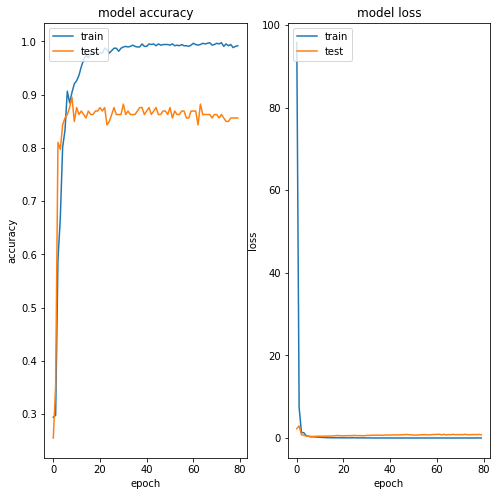

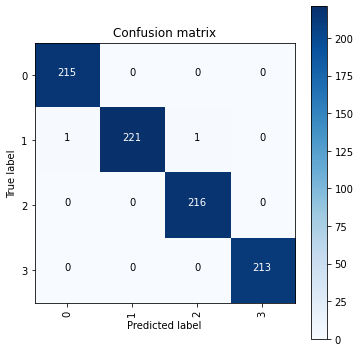

In [23]:
# Results on Train Set

score = trained_model.evaluate(xtrain, ytrain, verbose=0)
print('\nKeras CNN #1C - accuracy:', score[1],'\n')
print('Train loss:', score[0])
print('Train accuracy:', score[1])

y_pred = trained_model.predict(xtrain)
map_characters = label_dict
print('\n', sklearn.metrics.classification_report(np.where(ytrain > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.keys())), sep='')    
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(ytrain,axis=1)
# plotKerasLearningCurve()
# plt.show()  
plot_learning_curve(hist)
# plt.show()
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = [0, 1, 2, 3])
# plot_confusion_matrix(confusion_mtx, classes = list(label_dict.values())) 
plt.show()


Keras CNN #1C - accuracy: 0.8333333134651184 

Test loss: 0.930769681930542
Test accuracy: 0.8333333134651184
6/6 [==============================] - 0s 5ms/step

              precision    recall  f1-score   support

         eos       0.74      0.79      0.76        47
       lymph       0.91      0.94      0.93        33
        mono       1.00      0.92      0.96        50
      neutro       0.72      0.72      0.72        50

    accuracy                           0.83       180
   macro avg       0.84      0.84      0.84       180
weighted avg       0.84      0.83      0.84       180



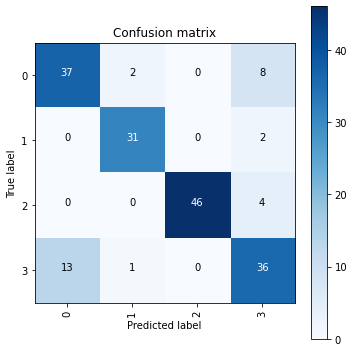

In [24]:
# Results on Test Set

score = trained_model.evaluate(xtest, ytest, verbose=0)
print('\nKeras CNN #1C - accuracy:', score[1],'\n')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

y_pred = trained_model.predict(xtest)
map_characters = label_dict
print('\n', sklearn.metrics.classification_report(np.where(ytest > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.keys())), sep='')    
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(ytest,axis=1)
# plotKerasLearningCurve()
# plt.show()  
# plot_learning_curve(hist)
plt.show()
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = [0, 1, 2, 3])
# plot_confusion_matrix(confusion_mtx, classes = list(label_dict.values())) 
plt.show()

In [27]:
# save the trained model
modelPath = basePath + '/models/'
trained_model.save(modelPath + 'cnn-aug.h5')

# save the history object
with open(modelPath + 'hist-cnn-aug.pickle', 'wb') as handle:
    pickle.dump(hist.history, handle, protocol=pickle.HIGHEST_PROTOCOL)